In [21]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform, exposure, filters, feature, color, data
import os
from os import listdir
from PIL import Image

In [22]:
path = r'New Masks Dataset'
classes = os.listdir(path)
classes

['.DS_Store', 'Test', 'Train']

In [23]:
myclasses = classes
myclasses.remove('.DS_Store')
myclasses

['Test', 'Train']

In [24]:
trainclasses = os.listdir(path + '/' + myclasses[1])
trainclasses.remove('.DS_Store')
trainclasses
p = os.listdir(path + '/Train/' + trainclasses[1])


In [25]:

traindata = []
trainlabels = []
trainfilenames = []

for classnum in range(len(trainclasses)):
    folder = path + '/Train/' + trainclasses[classnum]
    filelist = os.listdir(folder)
    np.random.shuffle(filelist)

    for i in range(len(filelist) - 1):
        if filelist[i] == '.DS_Store':
            filelist.remove('.DS_Store')
        filename = folder + '/' + filelist[i]
        image = io.imread(filename)
        if len(image.shape)>2:
            image = color.rgb2gray(image)
        image = transform.resize(image,[256, 256])
        fd = feature.hog(image, orientations=8, pixels_per_cell=(32, 32),
                    cells_per_block=(1, 1), visualize=False, multichannel=False)

        traindata.append(fd)
        trainlabels.append(classnum)
        trainfilenames.append(filename)

    print(classnum,end='\t')
    
traindata = np.array(traindata)
trainlabels = np.array(trainlabels)
trainfilenames = np.array(trainfilenames)

0	1	

(906, 512)

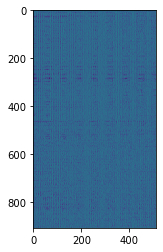

In [26]:
plt.imshow(traindata)
traindata.shape

In [27]:
testclasses = os.listdir(path + '/' + myclasses[0])
testclasses.remove('.DS_Store')
testclasses


['Non Mask', 'Mask']

In [28]:
#Reduce the dimensionality to 50
from sklearn.decomposition import PCA
pca = PCA(n_components=50,whiten=True)
lowtrain = pca.fit_transform(traindata)
traindata = lowtrain
lowtrain.shape

(906, 50)

In [29]:
from sklearn.svm import LinearSVC

model1 = LinearSVC()
model1.fit(traindata,trainlabels)


/Users/bvanegeren/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC()

In [30]:
o = 8
ppc = (32,32)
cpb = (1,1)
testdata = []
testlabels = []
testfilenames = []

for classnum in range(len(testclasses)):
    folder = path + '/Test/' + testclasses[classnum]
    filelist = os.listdir(folder)
    np.random.shuffle(filelist)

    for i in range(len(filelist) - 1):
        if filelist[i] == '.ipynb_checkpoints':
            filelist.remove('.ipynb_checkpoints')
        filename = folder + '/' + filelist[i]
        image = io.imread(filename)
        if len(image.shape)>2:
            image = color.rgb2gray(image)
        image = transform.resize(image,[256,256])
        fd = feature.hog(image, orientations=8, pixels_per_cell=(32, 32),
                    cells_per_block=(1, 1), visualize=False, multichannel=False)
        
        testdata.append(fd)
        testlabels.append(classnum)
        testfilenames.append(filename)

    print(classnum,end='\t')
    

testdata = np.array(testdata)
testlabels = np.array(testlabels)
testfilenames = np.array(testfilenames)

lowtest = pca.transform(testdata)
testdata = lowtest

guessedlabels = model1.predict(testdata)

0	1	

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

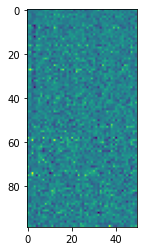

In [31]:
plt.imshow(testdata)
testdata.shape
testlabels

In [32]:
print(guessedlabels)


[0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1
 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1]


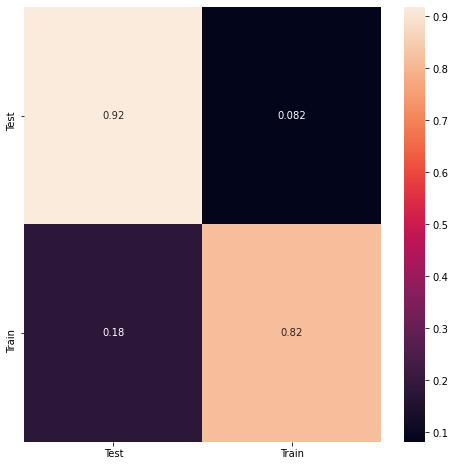

In [33]:
import seaborn as sn
import pandas as pd
numClasses = len(myclasses)

conf = np.zeros([numClasses,numClasses])

for image in range(len(testlabels)):
    real = testlabels[image]
    guess = guessedlabels[image]
    conf[real,guess] = conf[real,guess] + 1
 
rowsums = np.sum(conf,1)
rowsums = np.reshape(rowsums,[numClasses,1])
rowsums = np.repeat(rowsums,numClasses, axis = 1)
conf = conf / rowsums
df_cm = pd.DataFrame(conf, index = [i for i in myclasses],
                  columns = [i for i in myclasses])
plt.figure(figsize = (8,8))
sn.heatmap(df_cm, annot=True)

In [34]:
print(np.average(np.diag(conf)))

0.8691836734693877


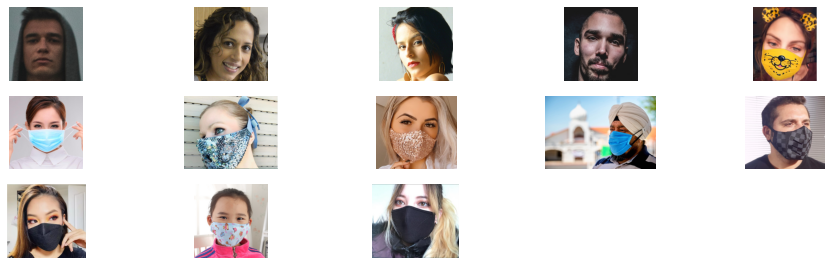

In [35]:
#Visualize wrong results
rows = 10
cols = 5
wrong = np.not_equal(guessedlabels,testlabels)
fig = plt.figure(figsize=(16, 16))
count = 0
for index in range(len(wrong)):
    if wrong[index]:
        count = count +1
        image = io.imread(testfilenames[index])
        temp = fig.add_subplot(rows, cols ,count)
        temp.imshow(image)
        temp.axis('off')
    if count==rows*cols:
        break